In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Visualize Pacman Logs

Before using this notebook execute `pacman_parse.py`, to create the csv from the original logs.

In [2]:
df = pd.read_csv("data/pacman_history.csv", parse_dates=["timestamp"])
df

,package,timestamp,action,version_before,version_after
0,linux-api-headers,2016-03-12 12:53:00,installed,NaN,4.4.1-1
1,tzdata,2016-03-12 12:53:00,installed,NaN,2016a-1
2,iana-etc,2016-03-12 12:53:00,installed,NaN,20151016-1
3,filesystem,2016-03-12 12:53:00,installed,NaN,2015.09-1
4,glibc,2016-03-12 12:53:00,installed,NaN,2.23-1
...,...,...,...,...,...
59650,webkit2gtk-4.1,2025-09-07 20:11:20,upgraded,2.48.5-1,2.48.6-1
59651,webkitgtk-6.0,2025-09-07 20:11:21,upgraded,2.48.5-1,2.48.6-1
59652,wireplumber,2025-09-07 20:11:21,upgraded,0.5.10-1,0.5.11-1
59653,xcb-util-cursor,2025-09-07 20:11:21,upgraded,0.1.5-1,0.1.6-1


The csv contains a line for each pacman action related to a package, it contains

- package: The package name
- timestamp: The time of the action
- action: The executed action can be `installed|upgraded|removed|reinstalled`
- version_before: empty if action is `installed`
- version_after: empty if actioin is `removed`

## Packages

Let's have some basic look at the packages

In [3]:
df.describe()

,timestamp
count,59655
mean,2021-07-07 02:17:57.412672768
min,2016-03-12 12:53:00
25%,2019-10-08 20:26:00
50%,2021-04-15 21:41:57
75%,2023-08-11 11:02:08
max,2025-09-07 20:11:21


In total there are 59655 lines of package actions, dating from March 12 2016 to September 7 2025. This should give some data to work with.

In [4]:
pkg_dist = df.groupby("package")["action"].count()
pkg_dist.describe()

count    2649.000000
mean       22.519819
std        42.018245
min         1.000000
25%         4.000000
50%        10.000000
75%        21.000000
max       535.000000
Name: action, dtype: float64

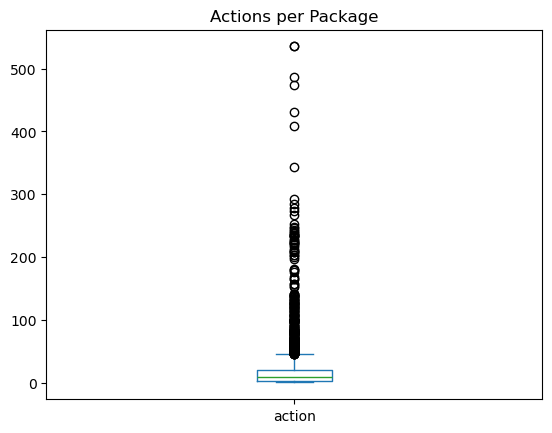

In [5]:
pkg_dist.plot.box()
plt.title("Actions per Package");

So half of the packages got no more then 10 actions over the whole time, with a few packages having up to 535 actions of the whole time. Let's make this a bit more detailed, by dividing it by action

## Package actions

In [6]:
action_counts = df["action"].value_counts()
action_counts

action
upgraded       53867
installed       3551
removed         1999
reinstalled      238
Name: count, dtype: int64

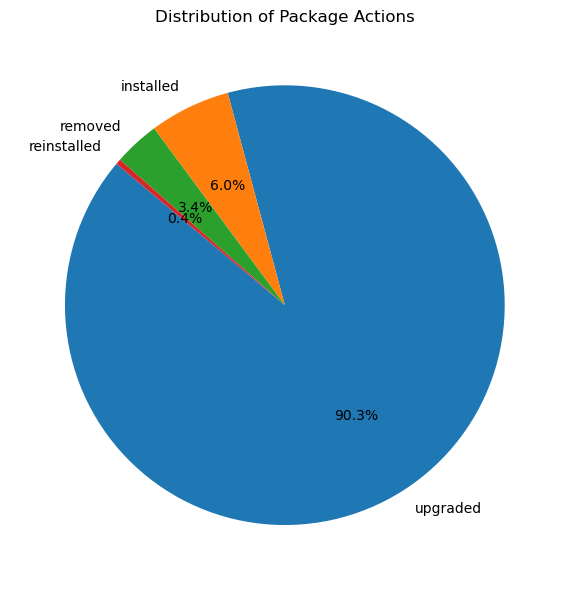

In [7]:
plt.figure(figsize=(6, 6))
action_counts.plot(kind="pie", autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Package Actions")
plt.ylabel("")
plt.tight_layout()

So most of the actions are actually upgrades.  Seems kind of obvious, if you are not installing/removing packages very frequently. Let's see, which packages are on top in each of the four action categories:

In [8]:
df.groupby("action")["package"].describe()

,count,unique,top,freq
action,,,,
installed,3551,2649,gendesk,22
reinstalled,238,143,st,37
removed,1999,1342,gendesk,22
upgraded,53867,2226,linux,534


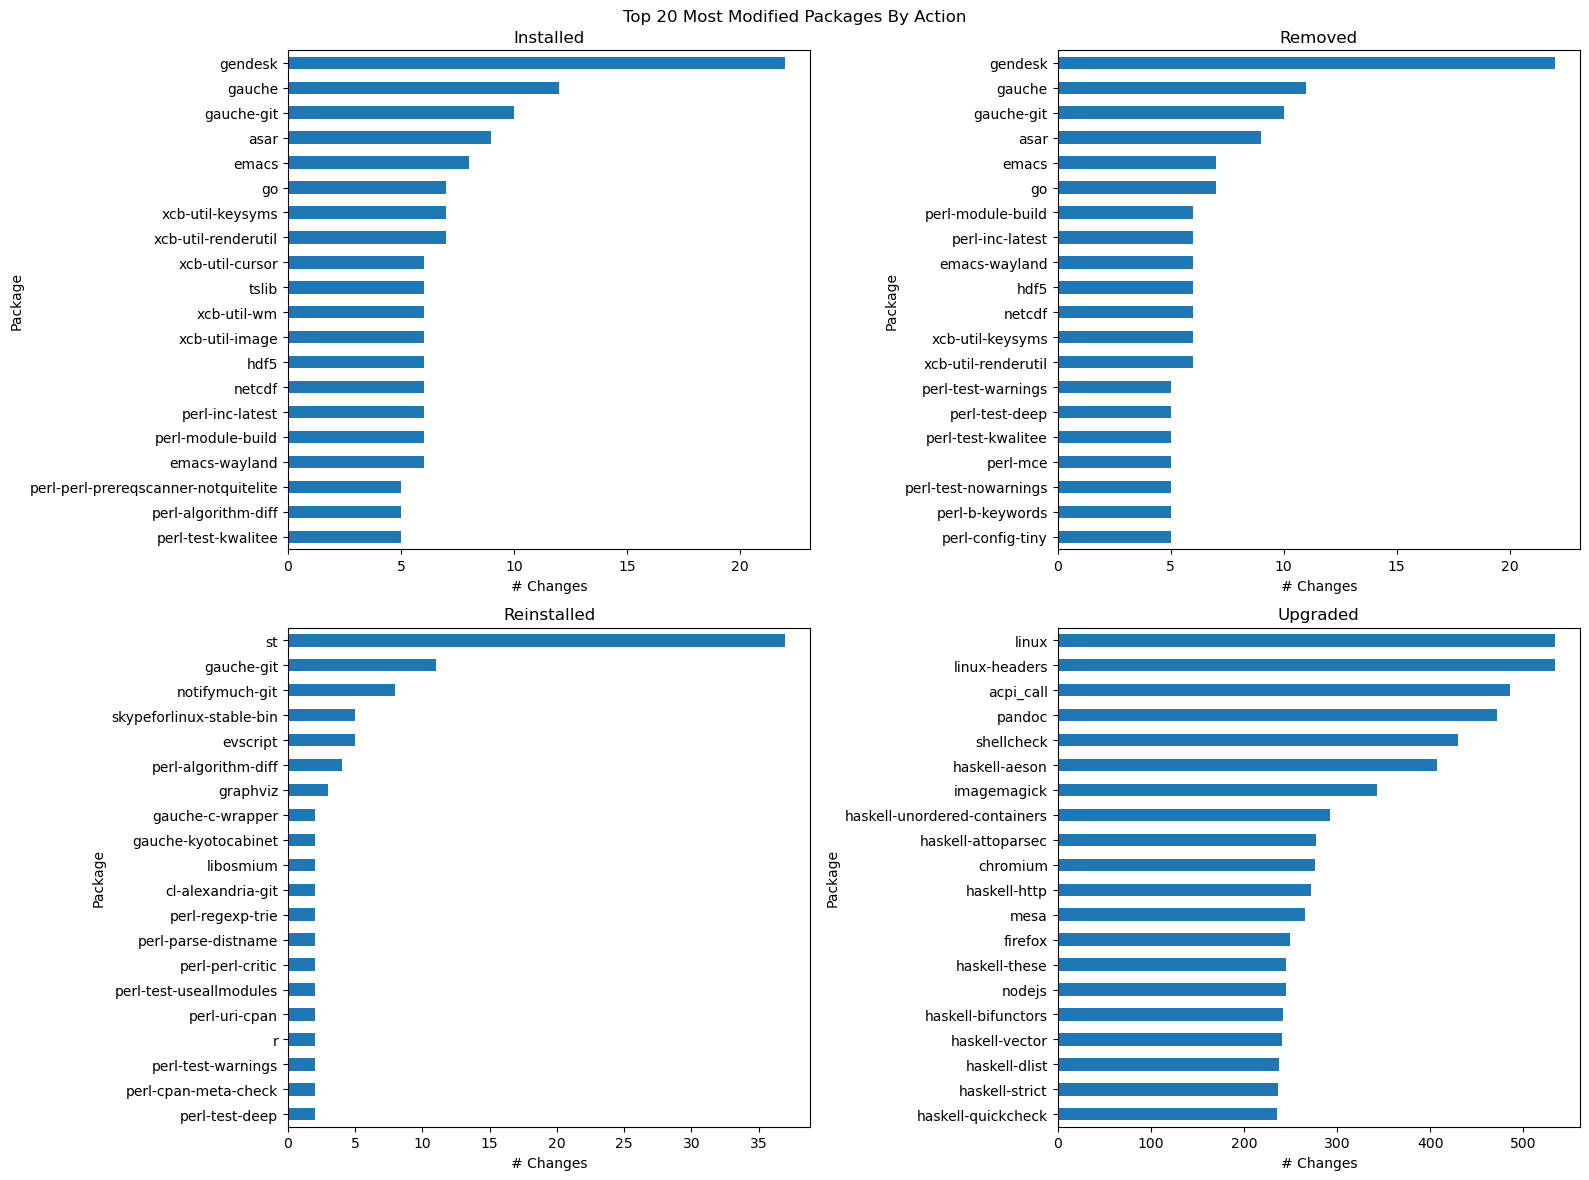

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
for i, action in enumerate(df["action"].unique()):
    data = df[df["action"] == action]["package"].value_counts().head(20)
    data.plot(kind="barh", ax=axes[i], title=action.capitalize())
    axes[i].set_ylabel("Package")
    axes[i].set_xlabel("# Changes")
    axes[i].invert_yaxis()
plt.suptitle("Top 20 Most Modified Packages By Action")
plt.tight_layout();

`gendesk` is a build dependency, which I regularly remove.  Regarding `gauche` I do package this for the aur and installed/removed this a couple of times, to test it.  `st` is on top of the reinstalls, as you need to rebuild, it, whenever you update the configuration, as it is common with suckless projects.

The upgrade plot is intersting more generally, as it does not show my personal habits.  The kernel is the most updated package with qute a margin, but also browsers and `nodejs` get very regular updates.

In [10]:
upgrade_df = df["upgraded" == df["action"]]
upgrade_count = upgrade_df.groupby("package")["action"].count()
upgrade_count.describe()

count    2226.000000
mean       24.199012
std        44.946614
min         1.000000
25%         4.000000
50%        10.000000
75%        23.000000
max       534.000000
Name: action, dtype: float64

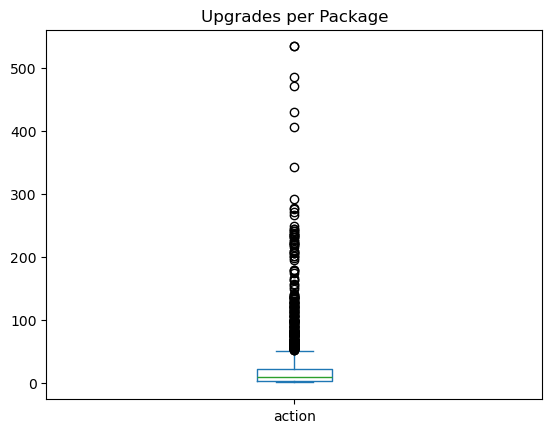

In [11]:
upgrade_count.plot.box()
plt.title("Upgrades per Package");

But as seen above, these are quite the outliers.  The average number of upgrades are around 24 per package. Now don't look only at the raw count of upgrades, but at the time distributions: 

In [35]:
pkg_times = upgrade_df.groupby(["package"]).apply(lambda x: x["timestamp"].sort_values().diff().dropna().dt.days, include_groups=False)
pkg_times.describe()

count    51641.000000
mean        64.340195
std        128.454793
min          0.000000
25%          5.000000
50%         19.000000
75%         61.000000
max       2724.000000
Name: timestamp, dtype: float64

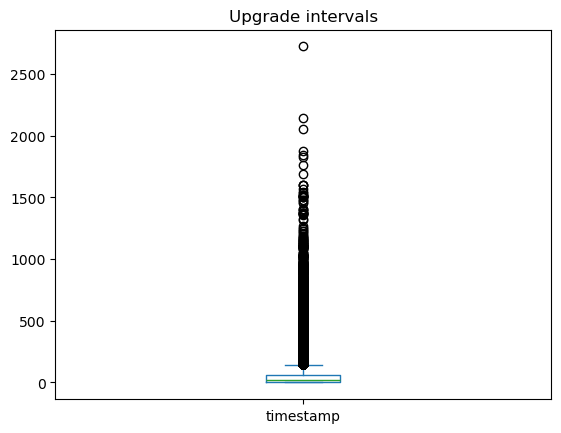

In [13]:
pkg_times.plot.box()
plt.title("Upgrade intervals");

So on average there is a update every 64 days, but this is very much skewed by some outliers, which get very inferquent updates.  Half of the upgrades happen every 19 days. The box plot is not very readable, so let's try something different.

In [36]:
pkg_times_group = pkg_times.groupby("package").describe().sort_values('count', ascending=False)
pkg_times_group

,count,mean,std,min,25%,50%,75%,max
package,,,,,,,,
linux,533.0,5.969981,5.055615,0.0,3.0,5.0,7.0,47.0
linux-headers,533.0,5.969981,5.055615,0.0,3.0,5.0,7.0,47.0
acpi_call,485.0,6.222680,5.852518,0.0,3.0,5.0,7.0,66.0
pandoc,471.0,3.169851,4.645385,0.0,1.0,2.0,4.0,46.0
shellcheck,429.0,3.750583,8.211616,0.0,1.0,1.0,4.0,115.0
...,...,...,...,...,...,...,...,...
scour,1.0,238.000000,NaN,238.0,238.0,238.0,238.0,238.0
sdl2_ttf,1.0,2148.000000,NaN,2148.0,2148.0,2148.0,2148.0,2148.0
haskell-math-functions,1.0,53.000000,NaN,53.0,53.0,53.0,53.0,53.0


<Axes: >

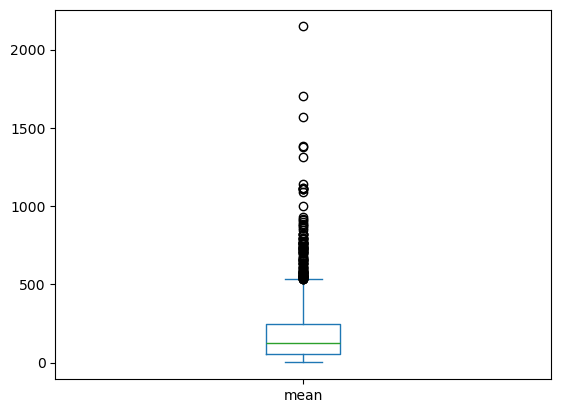

In [43]:
pkg_times_group["mean"].plot.box()

## Time based distribution

Let's look at some more information based on the timestamps.  First let's see, how they change over time.

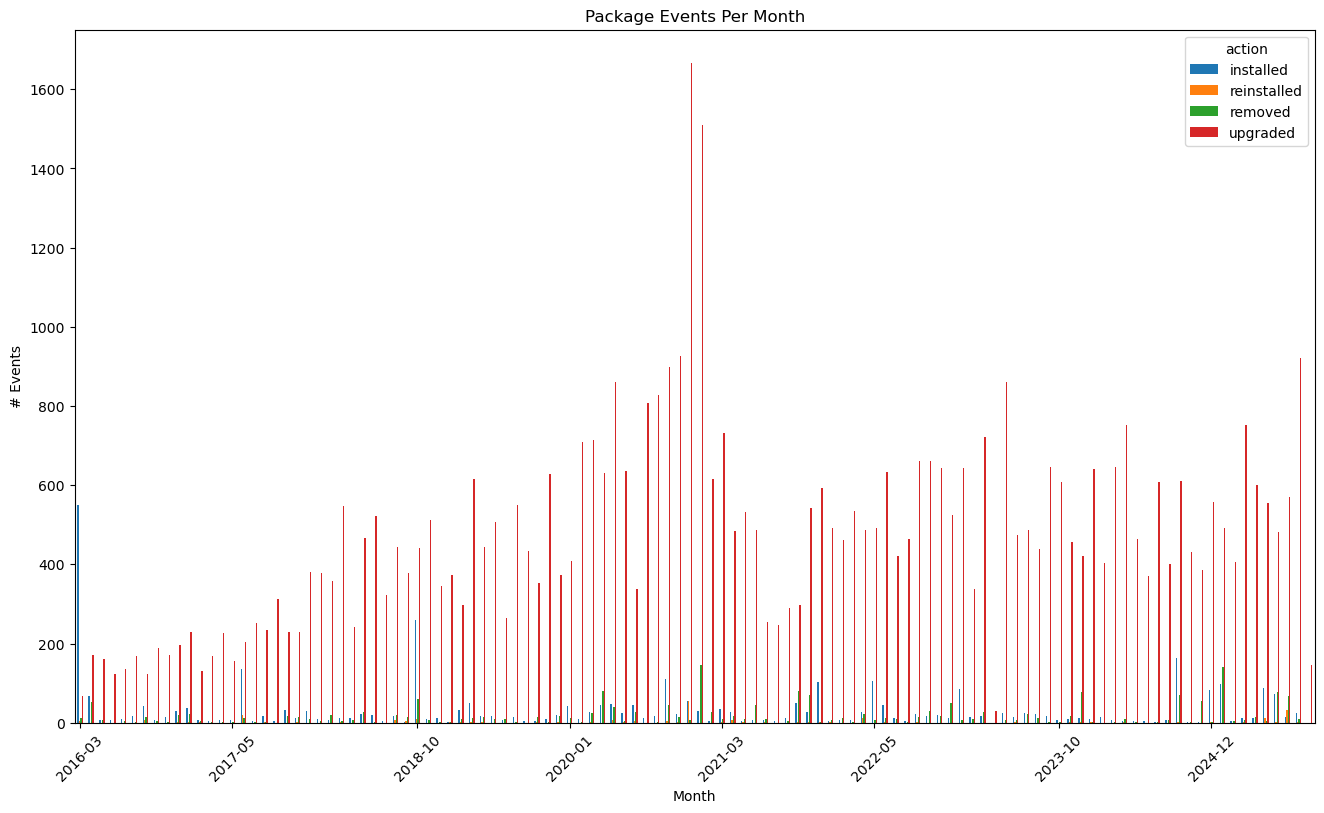

In [20]:
import matplotlib.dates as mdates

df["month"] = df["timestamp"].dt.to_period("M")
monthly_counts = df.groupby(["month", "action"]).size().unstack()
ax = monthly_counts.plot(kind="bar", figsize=(16, 9))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.title("Package Events Per Month")
plt.xlabel("Month")
plt.ylabel("# Events")
plt.xticks(rotation=45);

There are some spikes, of the installed action.  Obviously at the very beginning of the timeline and then in between.  The one in August 2018 is probably, when I switched from i3 to gnome as desktop environment.

Looking at the hourly data, one can maybe deduce, a pattern, when the PC is used:

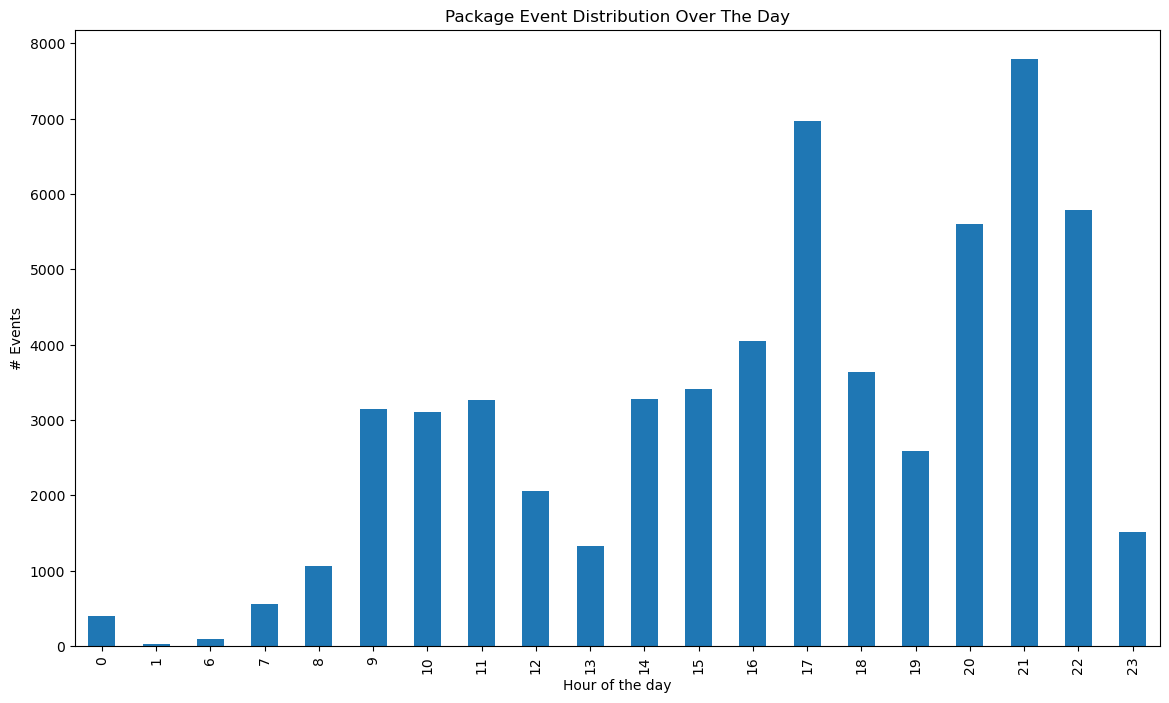

In [21]:
hourly_counts = df.groupby(df['timestamp'].dt.hour).size()
hourly_counts.plot(kind="bar", figsize=(14, 8))
plt.title("Package Event Distribution Over The Day")
plt.xlabel("Hour of the day")
plt.ylabel("# Events");

As this is my personal computer, it's mostly used in the evening.  Notice also there are no actions between 2 and 6 in the morning, but one after 1am :-)

## Timeline

I also build a timeline, which showes for each package, when it was installed.  But the visualization is a bit large, therefore it is not part of the notebook

# Conclusion

The visualizations here are only a very quick draft to see what can be done with the logs I discovered on my computer.  But it shows, that you can find a few intersting properties about the general update cycles of packages, as well as some information about the personal usage patterns.  If someone has further ideas, for intersting stuff to look at in the data, feel free to reach out.